In [1]:
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing import image

In [2]:
def load_batch(file_path):
    with open(file_path, 'rb') as f:
        data_dict = pickle.load(f, encoding='bytes')
    data = np.array(data_dict[b'data']).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    labels = np.array(data_dict[b'labels'])
    return data, labels

In [3]:
def load_cifar10_data(cifar10_dir):
    train_data = []
    train_labels = []

    for i in range(1, 6):
        batch_data, batch_labels = load_batch(os.path.join(cifar10_dir, f'data_batch_{i}'))
        train_data.append(batch_data)
        train_labels.append(batch_labels)

    train_data = np.concatenate(train_data)
    train_labels = np.concatenate(train_labels)

    test_data, test_labels = load_batch(os.path.join(cifar10_dir, 'test_batch'))

    return (train_data, train_labels), (test_data, test_labels)

In [13]:
#Load the CIFAR-10 dataset using the defined function:
cifar10_dir = 'D:/Egyetem/6.felev/DeepLearningI/Feleves/cifar-10-batches-py'
(train_images, train_labels), (test_images, test_labels) = load_cifar10_data(cifar10_dir)

In [14]:
#Normalize the images:
train_images, test_images = train_images / 255.0, test_images / 255.0

In [15]:
#Define the class names:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [16]:
#Function to display one image per class:
def display_sample_images(images, labels, class_names):
    fig = plt.figure(figsize=(10, 5))
    
    for class_idx, class_name in enumerate(class_names):
        plt.subplot(2, 5, class_idx + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        
        # Find the index of the first occurrence of the current class in the labels
        image_idx = np.where(labels == class_idx)[0][0]
        
        plt.imshow(images[image_idx], cmap=plt.cm.binary)
        plt.xlabel(class_name)
    
    plt.show()

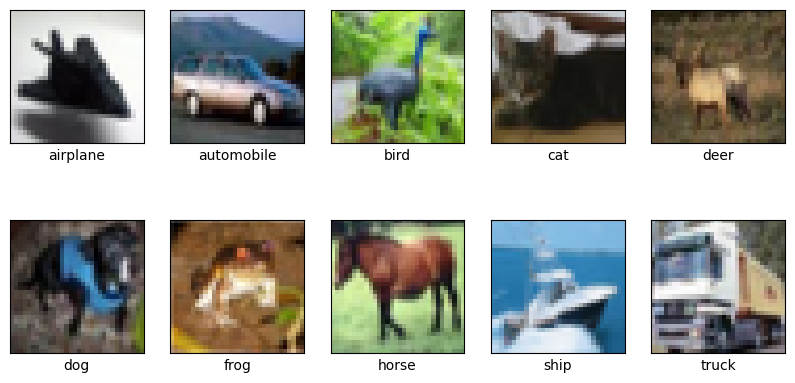

In [17]:
display_sample_images(train_images, train_labels, class_names)


In [18]:
#Split the training data into training and validation sets

train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42, stratify=train_labels)

In [19]:
#Create the CNN model

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

In [20]:
#Compile the model:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [21]:
models_folder = "models"
if not os.path.exists(models_folder):
    os.makedirs(models_folder)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
model_checkpoint = ModelCheckpoint(os.path.join(models_folder, 'best_model.h5'), monitor='val_loss', save_best_only=True, verbose=1)

history = model.fit(train_images, train_labels, epochs=20,
                    validation_data=(val_images, val_labels),
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/20


c:\Users\gabik\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1086/1250 [=========================>....] - ETA: 2s - loss: 1.5921 - accuracy: 0.4173

KeyboardInterrupt: 

In [22]:
# Evaluate the model on the test dataset
model = load_model('models/best_model.h5')

val_loss, val_mae = model.evaluate(X_val, y_val)
print(f"Validation MSE: {val_loss}")
print(f"Validation MAE: {val_mae}")

313/313 - 2s - loss: 0.9111 - accuracy: 0.6939 - 2s/epoch - 6ms/step

Test accuracy: 0.6938999891281128


In [23]:
#Visualize the training results:

def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [24]:
plot_history(history)

NameError: name 'history' is not defined

In [39]:
def predict_and_display(folder_path, model, class_names, images_per_row=5):
    image_files = os.listdir(folder_path)
    image_count = len(image_files)
    rows = int(np.ceil(image_count / images_per_row))
    
    fig = plt.figure(figsize=(15, 3 * rows))
    
    for i, img_file in enumerate(image_files):
        img_path = os.path.join(folder_path, img_file)
        img = image.load_img(img_path, target_size=(32, 32))
        img_array = image.img_to_array(img)
        img_normalized = img_array / 255.0
        img_expanded = np.expand_dims(img_normalized, axis=0)

        predictions = model.predict(img_expanded)
        predicted_class = np.argmax(predictions)

        plt.subplot(rows, images_per_row, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img_array.astype(np.uint8))
        plt.xlabel(class_names[predicted_class])

    plt.show()

In [ ]:
folder_path = "Images"
predict_and_display(folder_path, saved_model, class_names)